![license_header_logo](../../../images/license_header_logo.png)

> **Copyright (c) 2021 CertifAI Sdn. Bhd.**<br>
<br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

# Introduction

In this notebook, we will use PyTorch to build a **sequence 2 sequence (encoder-decoder) model** with **simple dot product attention using GRU** and evaluate their **attention scores**. We will further look into metrics like — **BLEU**, **ROUGE** for evaluating our model.


### Dataset used:
We will work on the **wikihow dataset**. If you cannot find the dataset in the `datasets` folder, you may download from [here](https://ucsb.box.com/s/ap23l8gafpezf4tq3wapr6u8241zz358).


This dataset is one of the large-scale datasets available for summarization with the length of articles varying considerably. It consists of more than 230,000 article and summary pairs extracted and constructed from an online knowledge base written by different human authors. The articles span a wide range of topics and therefore represent high diversity styles which make the summarization problem more challenging and interesting.

![wikihow](../../../images/wikihow.png)

# What will we accomplish?

Steps to implement text summarizer using PyTorch Deep Learning:

> Step 1: Data preprocessing using Pytorch

> Step 2: Building network model

> Step 3: Building model training and evaluation

> Step 4: Inference and prediction

# Notebook Content

* [Data Preparation](#Data-Preparation)
    * [Import Libraries](#Import-Libraries)
    * [Import Dataset](#Import-Dataset)
    * [Data Preprocessing](#Data-Preprocessing)
    * [Data Cleaning](#Data-Cleaning)
    * [Data Exploratory Analysis](#Data-Exploratory-Analysis)
    * [Train-Test Split](#Train-Test-Split)


* [Deep Model Design](#Deep-Model-Design)
    * [Seq2seq Model with Attention using GRU and Teacher Forcing](#Seq2seq-Model-with-Attention-using-GRU-and-Teacher-Forcing)
    * [Prepare Vocab](#Prepare-Vocab)
    * [Building Neural Network Model](#Building-Neural-Network-Model)
        * [Encoder](#Encoder)
        * [Decoder](#Decoder)
        * [Attention Mechanism](#Attention-Mechanism)
        * [Teacher Forcing](#Teacher-Forcing)
    * [Configure Training and Evaluation](#Configure-Training-and-Evaluation)
    * [Model Training](#Model-Training)
    * [Pickle Trained Model](#Pickle-Trained-Model)
    * [Load Trained Model](#Load-Trained-Model)
    
    
* [Model Evaluation Metrics](#Model-Evaluation-Metrics)


# Implementation of Abstractive Text Summarization

## Data Preparation

### Import Libraries

In [1]:
# For data preparation
import pandas as pd
import numpy as np

# For text cleaning
import nltk
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# For plotting
from matplotlib import pyplot as plt

In [2]:
# Download stopwords corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import Dataset

In [3]:
# Read wikihow dataset
df = pd.read_csv('../../../resources/day_08/wikihowAll.csv')

In [4]:
df.head()

,headline,title,text
0,"\r\nKeep related supplies in the same area.,\r...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\r\nCreate a sketch in the NeoPopRealist manne...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\r\nGet a bachelor’s degree.,\r\nEnroll in a s...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\r\nStart with some experience or interest in ...,How to Become an Art Investor,The best art investors do their research on t...
4,"\r\nKeep your reference materials, sketches, a...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."


In [5]:
df.describe()

,headline,title,text
count,214547,215364,214294
unique,214096,215364,209178
top,"\r\nAcquire a pot.,\r\nGather the ingredients ...",How to Be an Organized Artist1,",,"
freq,11,1,524


In [6]:
rows, columns = df.shape

print("Number of articles:", rows)
print("Number of columns:", columns)

Number of articles: 215365
Number of columns: 3


In [7]:
# Remove invalid articles
df = df[df['text'].isnull() == False]
df = df[df['text'] != 'nan']

df = df[df['headline'].isnull() == False]

In [8]:
# Drop duplicated articles
df.drop_duplicates(subset=['text'],inplace=True)

In [9]:
df

,headline,title,text
0,"\r\nKeep related supplies in the same area.,\r...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\r\nCreate a sketch in the NeoPopRealist manne...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\r\nGet a bachelor’s degree.,\r\nEnroll in a s...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\r\nStart with some experience or interest in ...,How to Become an Art Investor,The best art investors do their research on t...
4,"\r\nKeep your reference materials, sketches, a...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."
...,...,...,...
215360,\r\nConsider changing the spelling of your nam...,How to Pick a Stage Name3,"If you have a name that you like, you might f..."
215361,"\r\nTry out your name.,\r\nDon’t legally chang...",How to Pick a Stage Name4,Your name might sound great to you when you s...
215362,\r\nUnderstand the process of relief printing....,How to Identify Prints1,Relief printing is the oldest and most tradit...
215363,\r\nUnderstand the process of intaglio printin...,How to Identify Prints2,"Intaglio is Italian for ""incis­ing,"" and corr..."


### Data Preprocessing

Pre-processing and cleaning is an important step because building a model on unclean and messy data will in turn produce messy results. We will apply the below cleaning techniques before feeding our data to the model:

1. Converting all text to lower case for further processing


2. Parsing HTML tags


3. Removing text between ( ) and [ ]


4. Contraction Mapping — Replacing shortened version of words (for e.g. can’t is replaced with cannot and so on)


5. Removing apostrophe


6. Removing punctuations and special characters


7. Removing stop words using nltk library


8. Retaining only long words, i.e. words with length > 3

In [10]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text, num):
    # Lowercase characters
    txt = text.lower()
    
    # Parse HTML tags
    txt = BeautifulSoup(txt, "lxml").text
    
    # Remove text between () & []
    txt = re.sub(r'\([^)]*\)', '', txt)
    
    # Remove double quotation marks
    txt = re.sub('"','', txt)
    
    # Contraction mapping
    txt = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in txt.split(" ")])
    
    # Remove apostrophe
    txt = re.sub(r"'s\b","", txt)
    
    # Remove numbers and special characters
    txt = re.sub("[^a-zA-Z]", " ", txt)
    
    # Remove text with at least 2 consecutive same characters
    txt = re.sub('[m]{2,}', 'mm', txt)
    
    if(num == 0):
        txt = re.sub(r'\.',' . ', txt)
        tokens = [w for w in txt.split() if not w in stop_words]
    else:
        tokens=txt.split()
        
    long_words=[]
    for i in tokens:
        if len(i) > 1:          #removing short words
            long_words.append(i)
            
    return (" ".join(long_words)).strip()

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                       "could've": "could have", "couldn't": "could not","didn't": "did not", "doesn't": "does not", 
                       "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", 
                       "how'll": "how will", "how's": "how is","I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would","i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", 
                       "it'd": "it would","it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam","mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", "must've": "must have","mustn't": "must not",
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock","oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have","she'd": "she would", 
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                       "so've": "so have","so's": "so as","this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", 
                       "they'd've": "they would have","they'll": "they will", "they'll've": "they will have", 
                       "they're": "they are", "they've": "they have", "to've": "to have","wasn't": "was not", 
                       "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                       "we're": "we are","we've": "we have", "weren't": "were not", "what'll": "what will", 
                       "what'll've": "what will have", "what're": "what are","what's": "what is", "what've": "what have", 
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have","why's": "why is", "why've": "why have", "will've": "will have", 
                       "won't": "will not", "won't've": "will not have","would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all","y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have"}

### Data Cleaning

In [12]:
clean_text = []
for t in df['text']:
    clean_text.append(text_cleaner(t,0))

In [13]:
clean_summary = []
for t in df['headline']:
    clean_summary.append(text_cleaner(t,0))

In [14]:
df['text'] = clean_text
df['headline'] = clean_summary

df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

### Data Exploratory Analysis

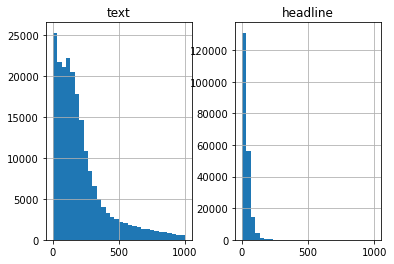

In [15]:
text_word_count = []
headline_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
    temp = i.split()
    text_word_count.append(len(temp))

for j in df['headline']:
    temp1 = j.split()
    headline_word_count.append(len(temp1))

length_df = pd.DataFrame({'text':text_word_count, 'headline':headline_word_count})
length_df.hist(bins=30,range=[0,1000])
plt.show()

In [16]:
# From the graph
# We can fix maximum length of text = 150 since most of the reviews have a length of 150 
# and maximum headline length of 50, since maximum headlines are of size 50

max_len_text = 150
max_len_headline = 50

In [17]:
cnt = 0
for i in df['text']:
    if(len(i.split()) <= max_len_text):
        cnt = cnt+1
        
print(cnt/len(df['text']))

0.4835030549898167


Selecting text and headlines below the maximum lengths

In [18]:
text = np.array(df['text'])
headline = np.array(df['headline'])

short_text=[]
short_summary=[]

for i in range(len(text)):
    if(len(headline[i].split()) <= max_len_headline and len(text[i].split()) <= max_len_text):
        short_text.append(text[i])
        short_summary.append(headline[i])
        
df = pd.DataFrame({'text':short_text, 'summary':short_summary})

In [19]:
print("Text:", df['text'][50], sep='\n')

print("\nSummary:", df['summary'][50], sep='\n')

Text:
guy like every facebook status update instagram picture post better yet frequently comment posts sign wants interact may indicate likes look see comments people posts well comments frequently may reveal avid social media user however rarely likes comments posts sign might feelings publicly comments one photos posts respond eager start conversation way may reveal likes least enjoys messaging example may say great photo could respond saying vancouver last week beautiful city guy met starts liking commenting old photos sig interested means spent time looking back old photos probably wants know better enjoys looking pictures guy likes want connect follow variety different social media platforms example may add facebook snapchat start following twitter instagram adding number social media sites likely sign wants look posts photos selfies attempt get know better

Summary:
see interacts posts reply comments notice comments old pictures posts check see added multiple social media platfor

### Train-Test Split

Here we using 70% for training set and 30% for test set

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['summary'], test_size=0.3, random_state=0, shuffle=True)

In [21]:
print("Number of training samples:", len(X_train), sep="\n")

print("\nNumber of testing samples:", len(X_test), sep='\n')

Number of training samples:
59676

Number of testing samples:
25576


## Deep Model Design

Before feeding the training data to our deep model, we will represent each word as a one-hot vector. We will then need a unique index per word to use it as the input and output of the network. In order to do so, we will create a helper class `Vocab` which has **(word-> index)** and **(index-> word)** mappings along with the count of each word.


To read data in our model, we have created pairs of our input and output in the form of a list **(pairs-> (Input, Output))**

### Seq2seq Model with Attention using GRU and Teacher Forcing

We will be using a seq2seq(encoder-decoder architecture) model with a simple dot product attention. The underlying idea of choosing this architecture is that we have a many-to-many problem at hand(n number of words as input and m number of words as output). The figure below shows the detailed architecture diagram for this model.

![Model Architecture](../../../images/GRUNN.png)

### Import Libraries

In [22]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Torch is using device", device)

Torch is using device cuda


### Prepare Vocab

In [24]:
SOS_token = 0
EOS_token = 1

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

In [25]:
def readData(text, summary, reverse=False):
    print("Reading lines...")
    
    # Split every line into pairs and normalize
    text = np.array(text)
    summary = np.array(summary)
    pairs = [(text[i], summary[i]) for i in range(len(text))]

    # Reverse pairs, make Vocab instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_vocab = Vocab(summary)
        output_vocab = Vocab(text)
    else:
        input_vocab = Vocab(text)
        output_vocab = Vocab(summary)

    return input_vocab, output_vocab, pairs

In [26]:
def prepareVocab(text, summary, reverse=False):
    input_vocab, output_vocab, pairs = readData(text, summary, reverse)
    
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_vocab.addSentence(pair[0])
        output_vocab.addSentence(pair[1])
        
    print("Counted words:")
    print(input_vocab.name, input_vocab.n_words)
    print("\n")
    print(output_vocab.name, output_vocab.n_words)
    
    return input_vocab, output_vocab, pairs

In [27]:
input_vocab, output_vocab, pairs = prepareVocab(X_train, y_train , False)

Reading lines...
Read 59676 sentence pairs
Counting words...
Counted words:
['save hardware later use remove styrofoam lining necessary proper fit grind sand ensure perfect fit'
 'food processor blender crumbs collect inside grater'
 'discounts might include deals airfare ticket options seating airport transportation many websites agencies offer budget travel options students around world destinations like los angeles although many airlines longer offer plans still offer discounts flight coupons domestic international travel'
 ...
 'icon looks like map located home screen located bottom map search box map zoom route starting location present first set directions menu pop display basic route information distance travel time eta see different icons gas stations dinner locations coffee shops etc depending location time day map present list nearby locations choose fit category currently method adding custom pit stop additional destination route multiple stops need set new route destination

In [28]:
print(random.choice(pairs))

('set counter toast long needed favorite level toasting bread toasting grab plate napkin get peanut butter jelly jam knife spoon spread bread toasted liking lay toast plate breadboard use separate knives spread avoid leaving traces spread opposite jar using butter knife scoop big hunk peanut butter place one slice toast spread melts bread cover toast thick layer peanut butter like use little much like evenly distribute two spreads press together form toasted sandwich enjoy snack', 'plug toaster grab ingredients take two slices bread put toaster wait toast done place toast preparation surface spread jelly jam toast overlapping peanut butter finished')


### Building Neural Network Model

In [29]:
SOS_token = 0
EOS_token = 1

In [30]:
def indexesFromSentence(vocab, sentence):
    return [vocab.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(vocab, sentence):
    indexes = indexesFromSentence(vocab, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_vocab, pair[0])
    target_tensor = tensorFromSentence(output_vocab, pair[1])
    return (input_tensor, target_tensor)

#### Encoder

The encoder layer of the seq2seq model **extracts information** from the input text and encodes it into a single vector, that is a **context vector**. Basically, for each input word, the encoder generates a hidden state and a vector , using this hidden state for the next input word.

We have used GRU(Gated Recurrent Unit) for the encoder layer in order to **capture long term dependencies** - mitigating the vanishing/exploding gradient problem encountered while working with vanilla RNNs. The GRU cell reads one word at a time and using the update and reset gate, computes the hidden state content and cell state.

In [31]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Decoder

The decoder layer of a seq2seq model uses the last hidden state of the encoder i.e. the **context vector** and generates the output words. The decoding process starts once the sentence has been encoded and the decoder is given a **hidden state** and an input token at each step/time.

At the initial time stamp/state the first hidden state is the context vector and the input vector is **SOS(start-of-string)**. The decoding process ends when **EOS(end-of-sentence)** is reached. The SOS and EOS tokens are explicitly added at the start and end of each sentence respectively.

In [32]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Attention Mechanism

Using the encoder-decoder architecture, the **encoded context vector** is passed on to the decoder to generate an output sentence. Now what if the input sentence is long and a single context vector cannot capture all the important information. **This is where attention comes into picture!!!**

The main intuition of using attention is to allow the model to **focus/pay attention** on the most important part of the input text. As a blessing in disguise, it also helps to **overcome the vanishing gradient problem**. There are different types of attention — additive, multiplicative, however, we will use the basic dot product attention for our model.


1. Attention scores are first calculated by computing the **dot product of the encoder(h) and decoder(s) hidden state**


2. These attention scores are converted to a **distribution(α)** by passing them through the **Softmax layer**.


3. Then the **weighted sum of the hidden states (z)** is computed.


4. This z is then **concatenated with s** and fed through the softmax layer to generate the words using ‘**Greedy Algorithm**’ (by computing argmax)

In this architecture, instead of directly using the output of last encoder’s hidden state, we are also feeding the **weighted combination of all the encoder hidden states**. This helps the model to pay attention to important words across long sequences.

**Supporting Equations**

![Attention Equations](../../../images/attentionEquation.png)

In [33]:
MAX_LENGTH = 150

In [34]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Teacher Forcing

In general, for recurrent neural networks, the output from a state is fed as an input to the next state. This process causes slow convergence thereby increasing the training time.



#### What is Teacher Forcing

Teacher forcing addresses this slow convergence problem by feeding the **actual value/ground truth** to the model. The basic intuition behind this technique is that instead of feeding the decoders predicted output as an input for the next state, the ground truth or the actual value is fed to the model. If the model predicts a wrong word it might lead to a condition wherein all the further words that are predicted are incorrect. Hence, teacher forcing feeds the actual value thereby **correcting the model** if it predicts/generates a wrong word.

Teacher forcing is a fast and effective way to train RNNs, however, this approach may result in ***more fragile/unstable models*** when the generated sequences vary from what was seen during the training process.
To deal with such an isssue, we will follow an approach that involves randomly choosing to use the ground truth output or the generated output from the previous time step as an input for current time step.

In [35]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

### Configure Training and Evaluation

In [36]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [37]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [38]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    print("Training....")
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        if iter% 1000 == 0:
            print(iter,"/",n_iters + 1)
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        input_length = input_tensor.size(0)
        if(input_length > 150):
          #print(input_length)
          continue

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [39]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_vocab, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_vocab.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

### Model Training

Training....
1m 46s (- 353m 27s) (500 0%) 5.8764
1000 / 100001
3m 20s (- 331m 22s) (1000 1%) 6.2445
4m 56s (- 324m 2s) (1500 1%) 6.0801
2000 / 100001
6m 36s (- 323m 54s) (2000 2%) 6.3151
8m 10s (- 318m 52s) (2500 2%) 6.0685
3000 / 100001
9m 48s (- 316m 58s) (3000 3%) 5.8522
11m 21s (- 312m 57s) (3500 3%) 5.6258
4000 / 100001
12m 57s (- 310m 50s) (4000 4%) 5.7877
14m 31s (- 308m 5s) (4500 4%) 5.6872
5000 / 100001
16m 7s (- 306m 19s) (5000 5%) 5.8692
17m 43s (- 304m 31s) (5500 5%) 5.8990
6000 / 100001
19m 18s (- 302m 35s) (6000 6%) 5.7065
20m 51s (- 300m 9s) (6500 6%) 5.5286
7000 / 100001
22m 28s (- 298m 40s) (7000 7%) 5.7503
24m 8s (- 297m 49s) (7500 7%) 5.7814
8000 / 100001
25m 42s (- 295m 39s) (8000 8%) 5.6480
27m 17s (- 293m 49s) (8500 8%) 5.3671
9000 / 100001
28m 50s (- 291m 34s) (9000 9%) 5.6408
30m 23s (- 289m 32s) (9500 9%) 5.7285
10000 / 100001
31m 48s (- 286m 12s) (10000 10%) 5.6263
33m 15s (- 283m 27s) (10500 10%) 5.9679
11000 / 100001
34m 42s (- 280m 49s) (11000 11%) 5.4814
3

265m 39s (- 37m 57s) (87500 87%) 5.2507
88000 / 100001
267m 11s (- 36m 26s) (88000 88%) 5.3485
268m 41s (- 34m 54s) (88500 88%) 5.2585
89000 / 100001
270m 8s (- 33m 23s) (89000 89%) 5.1311
271m 39s (- 31m 52s) (89500 89%) 5.3655
90000 / 100001
273m 10s (- 30m 21s) (90000 90%) 5.3830
274m 38s (- 28m 49s) (90500 90%) 5.4955
91000 / 100001
276m 14s (- 27m 19s) (91000 91%) 5.3753
277m 45s (- 25m 48s) (91500 91%) 5.3277
92000 / 100001
279m 22s (- 24m 17s) (92000 92%) 5.4159
280m 56s (- 22m 46s) (92500 92%) 5.4032
93000 / 100001
282m 31s (- 21m 15s) (93000 93%) 5.3261
284m 6s (- 19m 45s) (93500 93%) 5.2404
94000 / 100001
285m 42s (- 18m 14s) (94000 94%) 5.3669
287m 15s (- 16m 43s) (94500 94%) 5.2596
95000 / 100001
288m 46s (- 15m 11s) (95000 95%) 5.4422
290m 21s (- 13m 40s) (95500 95%) 5.3271
96000 / 100001
291m 50s (- 12m 9s) (96000 96%) 5.3535
97000 / 100001
294m 49s (- 9m 7s) (97000 97%) 10.3459
296m 20s (- 7m 35s) (97500 97%) 5.2246
98000 / 100001
297m 49s (- 6m 4s) (98000 98%) 5.2454
29

<Figure size 432x288 with 0 Axes>

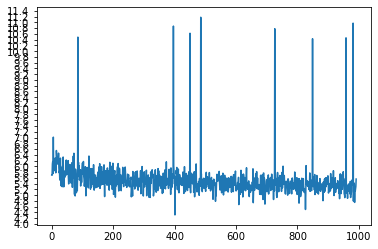

In [40]:
hidden_size = 300
encoder1 = EncoderRNN(input_vocab.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_vocab.n_words, dropout_p=0.1).to(device)

# This is just a tutorial, therefore we only use 3000 epochs here
trainIters(encoder1, attn_decoder1, 100000, print_every=500)

### Save Trained Model

In [41]:
torch.save(encoder1, "model/encoder.model")
torch.save(attn_decoder1, "model/decoder.model")

### Load Trained Model
This pretrained model is not optimized and you may expect low accuracy

In [42]:
encoder1 = torch.load("model/encoder.model")
attn_decoder1 = torch.load("model/decoder.model")

In [43]:
for p in encoder1.parameters():
    if p.requires_grad:
         print(p.data)

tensor([[ 1.0284, -1.0606,  0.0629,  ..., -0.3006, -0.3855,  1.4225],
        [ 0.2433,  0.2984,  1.3664,  ..., -0.0368,  0.0760,  0.3301],
        [-0.1069, -0.9138,  1.7072,  ...,  1.6283,  0.5255,  0.7051],
        ...,
        [ 0.1800,  1.1256,  0.6946,  ..., -0.3186, -0.3207,  0.0827],
        [ 1.5827,  0.5843,  1.1109,  ..., -0.3587, -0.0601,  0.6484],
        [ 1.8425,  0.6422, -1.0052,  ...,  0.6684,  0.4895,  0.2602]],
       device='cuda:0')
tensor([[-5.5133e-02,  7.1059e-02,  6.2996e-02,  ...,  6.2187e-02,
          1.8284e-02,  1.3226e-02],
        [-3.5551e-02, -2.2046e-02, -4.2452e-02,  ...,  2.8883e-02,
          4.2148e-02, -4.7835e-04],
        [-9.0124e-02, -1.4641e-02,  1.2347e-02,  ..., -8.1382e-03,
         -1.0085e-03, -4.6588e-02],
        ...,
        [ 4.2197e-01,  3.0737e-01,  4.7557e-04,  ..., -1.1926e-01,
          5.3730e-02, -3.7813e-01],
        [-1.8955e-01, -2.5875e-01, -5.6589e-02,  ...,  1.4348e-01,
          1.0287e-01,  4.8600e-01],
        [-2.92

In [44]:
for p in attn_decoder1.parameters():
    if p.requires_grad:
         print(p.data)

tensor([[-1.4535, -0.8212,  0.7829,  ...,  0.0507,  0.4352, -1.9595],
        [ 0.3427,  2.7124, -0.2625,  ..., -0.1007,  1.1083, -0.0552],
        [ 0.1731,  0.6942,  0.2450,  ...,  0.5388, -1.0690,  0.1895],
        ...,
        [-0.5880,  0.1559, -0.1740,  ..., -0.7984, -0.2060, -0.7826],
        [-0.7874, -0.8534,  0.9255,  ...,  0.9693,  0.4033, -1.3736],
        [-0.6242,  0.2627,  0.8259,  ...,  0.2791, -0.2974, -0.4235]],
       device='cuda:0')
tensor([[ 0.0266,  0.0106,  0.0733,  ...,  0.0305,  0.0089, -0.0266],
        [ 0.0096,  0.0895,  0.0007,  ..., -0.0385, -0.0006, -0.0526],
        [-0.0256,  0.0329,  0.0722,  ...,  0.1478,  0.0752,  0.0207],
        ...,
        [ 0.1107,  0.0652,  0.1063,  ...,  0.1272,  0.0135, -0.0240],
        [-0.0261,  0.1426, -0.0542,  ...,  0.0939, -0.0175, -0.0344],
        [ 0.1269,  0.0455,  0.0257,  ...,  0.1265,  0.0187, -0.0598]],
       device='cuda:0')
tensor([ 0.1040,  0.0864,  0.4179,  0.1586,  0.0366,  0.0591,  0.1475,  0.0431,
    

tensor([-6.8911e-02,  2.2901e+00,  7.8043e-01,  ..., -1.6430e-02,
        -8.3252e-04, -3.8392e-02], device='cuda:0')


### Model Prediction

In [45]:
def evaluateRandomly(encoder, decoder, n=5):
    text = list()
    headline = list()
    pred_headline = list()
    
    for i in range(n):
        pair = random.choice(pairs)
        
        if(len(pair[0].split())>=150):
            continue
        else:
            if(i%1000 == 0):
                print(i*100/n,"% complete")

            # print('>', pair[0])
            text.append(pair[0])
            # print('=', pair[1])
            headline.append(pair[1])
            output_words, attentions = evaluate(encoder, decoder, pair[0])
            output_sentence = ' '.join(output_words)
            pred_headline.append(output_sentence)
            # print('<', output_sentence)
            # print('')
            
    return(text,headline,pred_headline)

In [46]:
text,headline,pred_headline = evaluateRandomly(encoder1, attn_decoder1, 15000)

pred_df_GRU = pd.DataFrame()

pred_df_GRU['text'] = text
pred_df_GRU['headline'] = headline
pred_df_GRU['pred_headline'] = pred_headline

0.0 % complete
6.666666666666667 % complete
13.333333333333334 % complete
20.0 % complete
26.666666666666668 % complete
33.333333333333336 % complete
40.0 % complete
46.666666666666664 % complete
53.333333333333336 % complete
60.0 % complete
66.66666666666667 % complete
73.33333333333333 % complete
80.0 % complete
86.66666666666667 % complete
93.33333333333333 % complete


In [47]:
pred_df_GRU

,text,headline,pred_headline
0,ends drying subjecting drying saliva containin...,lick lips constantly use high quality lip glos...,get good sized bowl mix honey water bowl mix a...
1,hair loose classic way wear prevents lot damag...,wear hair straight wear curly get wavy hair ma...,brush hair brush brush brush brush brush brush...
2,draw cross section inside circle facing right ...,draw small circle tail line draw stick figures...,draw circle head head head one two circle one ...
3,wash roma tomato faucet turning necessary wash...,wash tomato remove top cut tomato half cut tom...,place half cut place cut half place place <EOS>
4,conducted plumpy nut challenge increase awaren...,contact merlin charity uk sign plumpy nut chal...,check whether check check <EOS>
...,...,...,...
14904,uber available selected location redirected ci...,open uber cities website click find city field...,open uber app tap tap tap location tap tap loc...
14905,dispenser usually shoot farthest however items...,see far shoot get average items remember dropp...,go find find find find go find find find go fi...
14906,stiff skin syndrome characterized development ...,check surface body hard thick skin test joint ...,get water water water water water get water wa...
14907,stand straight heels together toes pointed out...,stand correctly bring elbow knee together brin...,try leg leg leg leg forward leg one leg <EOS>


In [48]:
pred_df_GRU.to_csv('model/Attention_GRU_Pred.csv',sep='\t',index=False,header=True)

## Model Evaluation Metrics

For our text summarization problem, there can be multiple correct answers and as we do not have a single correct output, we can evaluate our model using different parameters like — Recall, Precision, F-score. Below are some of the metrics:

* **BLEU(Bilingual Evaluation Understudy)**: The cornerstone of this metric is precision having values between [0,1], wherein 1 represents a perfect match and 0 represents a complete mismatch. This metric is basically calculated by comparing the number of machine-generated words that are a part of the reference sentence with respect to the total number of words in the machine-generated output.


* **ROUGE (Recall-Oriented Understanding for Gisting Evaluation)**: A recall-oriented measure that works by comparing the number of machine-generated words that are a part of the reference sentence with respect to the total number of words in the reference sentence.

    This metric is more intuitive in the sense that every time we add a reference to the pool, we expand our space of alternating summaries. Hence, this metric should be preferred when we have multiple references.
    
    ROUGE implementation is pretty similar to BELU, however, there are other underlying implementations like LCS (Longest common subsequence) and skip-gram, etc. We can directly use the ROUGE-N implementation using the python library ROUGE.
    

In this tutorial, we will use ROUGE to evaluate the model.


**Recall, r**
The recall counts the number of overlapping n-grams found in both the model output and reference — then divides this number by the total number of n-grams in the reference. This is great for ensuring our model is capturing all of the information contained in the reference — but this isn’t so great at ensuring our model isn’t just pushing out a huge number of words to game the recall score.


**Precision, p**
To avoid this we use the precision metric — which is calculated in almost the exact same way, but rather than dividing by the reference n-gram count, we divide by the model n-gram count.


**F1-Score, f**
Now that we both the recall and precision values, we can use them to calculate our ROUGE F1 score like so:
![F1_score](../../../images/F1.png)

That gives us a reliable measure of our model performance that relies not only on the model capturing as many words as possible (recall) but doing so without outputting irrelevant words (precision).

In [49]:
# !pip install rouge
import nltk
from rouge import Rouge

rouge = Rouge()

rouge.get_scores(pred_df_GRU['pred_headline'], pred_df_GRU['headline'], avg=True)

{'rouge-1': {'r': 0.08824770650530915,
  'p': 0.234780419508386,
  'f': 0.11945047228398172},
 'rouge-2': {'r': 0.013882968414462099,
  'p': 0.027146369772616856,
  'f': 0.016841815053443242},
 'rouge-l': {'r': 0.08238563805616168,
  'p': 0.21928321945281865,
  'f': 0.11142691640129991}}

# Extension

The current model is only used for demo purpose and can be optimized by further tuning the hyperparameters (learning rate, optimizer, loss function, hidden layers, momentum, iterations, etc.)

You also can try different algorithms and neural network architectures:

1. Bi-directional/stacked GRU cells can be used for improving performance


2. Implementing different kinds of attention-mechanism — multiplicative attention, multi-head attention, etc.


3. Output words can be selected using beam search instead of greedy-algorithm

# Contributors

**Author**
<br>Chee Lam

# References

1. [Text Summarization Using Deep Neural Networks](https://towardsdatascience.com/text-summarization-using-deep-neural-networks-e7ee7521d804)